# Metropolis-Hasting MCMC sampling of a Poisson distribution 

This notebook was adapted from Example 1, section 12.2 in Gregory's *Bayesian Logical Data Analysis for the Physical Sciences*.

The Poisson discrete random variable from scipy.stats is defined by (see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html))

$$
p(k|\mu) = \frac{\mu^k e^{-\mu}}{k!} \quad \mbox{for }k\geq 0 \;.
$$

where $k$ is an integer and $\mu$ is called the shape parameter. The mean and variance of this distribution are both equal to $\mu$. (Note: Gregory uses a different notation, but we'll stay consistent with scipy.stats.)

By "sampling a Poisson distribution" we mean we will obtain a set of $k$ values: $\{k_1, k_2, k_3, \ldots\}$ that follow this distribution.  That is, for a particular $k_i$, the probability to get that value should be what we get by evaluating $p(k_i|\mu)$. We know we've succeeded if we make a histogram of our set of $k_i$s and it looks like $p(k|\mu)$ (scaled to line up or else our histogram needs to be normalized to one).

The method we'll use is generically called Markov chain Monte Carlo or MCMC.  A Markov chain starts with some initial value, and then each successive value is generated from the previous one.  But it is not deterministic: when the new value is chosen, there is a random number involved.  The particular version of MCMC used here is called Metropolis-Hasting. You may be familiar with this from a statistical mechanics class, where it is typically applied to the Ising model.

We'll do the Metropolis-Hasting sampling as follows:
1. Choose an initial $k$ (call it $k_0$), having already fixed $\mu$.
2. Given $k_i$, sample a uniform random number $x$ from 0 to 1 (so $x \sim U(0,1)$) and propose $k' = k_i + 1$ if the $x > 0.5$, otherwise propose $k' = k_i - 1$.
3. Compute the Metropolis ratio $r = p(k'|\mu)\, /\, p(k_i|\mu)$ using the discrete Poisson distribution.
4. Given another uniform random number $y \sim U(0,1)$, $k_{i+1} = k'$ if $y \leq r$, else $k_{i+1} = k_i$ (i.e., keep the same value for the next $k$).
5. Repeat 2.-4. until you think you have enough samples of $k$.
6. When graphing the posterior or calculating averages, skip the first values until the sampling has equilibrated (this is generally called the "burn-in" or "warm-up").

In practice we'll carry this out by generating all our uniform random numbers at the beginning using `scipy.stats.uniform.rvs`.

In [1]:
%matplotlib inline  

import numpy as np
from math import factorial

# We'll get our uniform distributions from stats, but there are other ways.
import scipy.stats as stats  

import matplotlib.pyplot as plt
import seaborn; seaborn.set(); seaborn.set_context("talk") # for nicer plot formatting

In [2]:
def poisson(k, mu):
    """
    Returns a Poisson distribution value for k with mean mu
    """
    return mu**k * np.exp(-mu) / factorial(k) 

In the following we have the steps 1-6 defined above marked in the code. *Step through the implementation and ask questions about what you don't understand.*

 MCMC mean = 2.98
Exact mean = 3.00
   MCMC sd = 1.72
  Exact sd = 1.73


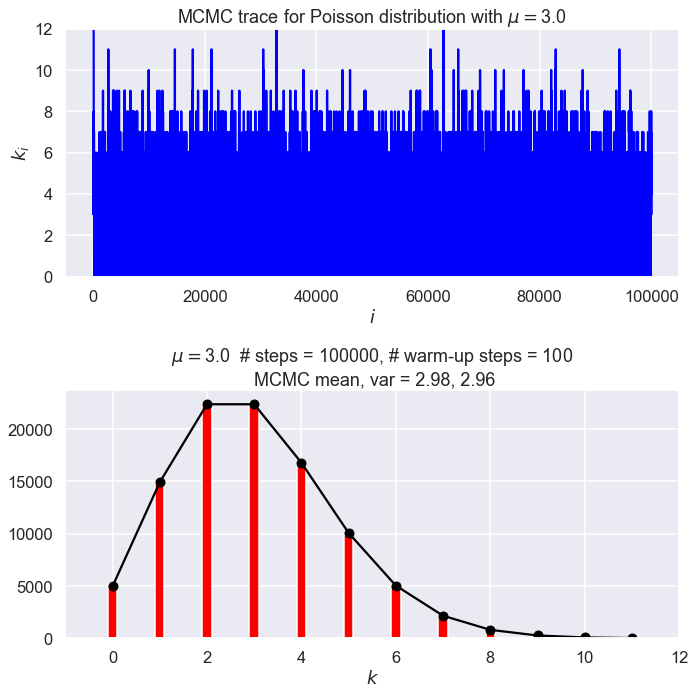

In [3]:
# 1. Set mu and k0
mu = 3.
k0 = 50    

num_steps = 100000  # number of MCMC steps we'll take
# generate the two sets of uniform random numbers we'll need for 2. and 4.
uniform_1 = stats.uniform.rvs(size=num_steps)  
uniform_2 = stats.uniform.rvs(size=num_steps)

k_array = np.zeros(num_steps, dtype=int)
k_array[0] = k0

# 5. Loop through steps 2-4
for i in range(num_steps-1):  # num_steps-1 so k_array[i+1] is always defined
    # 2. Propose a step
    k_now = k_array[i]
    if uniform_1[i] > 0.5:
        kp = k_now + 1          # step to the right
    else:
        kp = max(0, k_now - 1)  # step to the left, but don't go below zero
    
    # 3. Calculate Metropolis ratio
    metropolis_r = poisson(kp, mu) / poisson(k_now, mu)
    # 4. Accept or reject
    if uniform_2[i] <= metropolis_r:
        k_array[i+1] = kp
    else:
        k_array[i+1] = k_now

# 6. Choose how many steps to skip
warm_up_steps = 100

# Check the mean and standard deviations from the samples against exact
MCMC_mean = np.mean(k_array[warm_up_steps:])
MCMC_sd = np.std(k_array[warm_up_steps:])
print(f' MCMC mean = {MCMC_mean:.2f}')
print(f'Exact mean = {stats.poisson.mean(mu=mu):.2f}')
print(f'   MCMC sd = {MCMC_sd:.2f}')
print(f'  Exact sd = {stats.poisson.std(mu=mu):.2f}')      

# Set up for side-by-side plots
fig = plt.figure(figsize=(10,10))

# Plot the trace (that means k_i for i=0 to num_steps)
ax_trace = fig.add_subplot(2, 1, 1)    
ax_trace.plot(range(num_steps), k_array, color='blue')
ax_trace.set_ylim(0, 12)
ax_trace.set_xlabel(r'$i$')
ax_trace.set_ylabel(r'$k_i$')
trace_title = rf'MCMC trace for Poisson distribution with $\mu = ${mu:.1f}'
ax_trace.set_title(trace_title)

# Plot the Poisson distribution
ax_plot = fig.add_subplot(2, 1, 2)
bin_num = 12
n_pts = range(bin_num)
    
# Scale exact result to the histogram, accounting for warm_up_steps    
poisson_pts = [(num_steps - warm_up_steps) * poisson(n, mu) for n in n_pts]     
    
# Plot the exact distribution    
ax_plot.plot(n_pts, poisson_pts, marker='o', color='black') 
# Histogram k_i beyond the warm-up period
ax_plot.hist(k_array[warm_up_steps:], bins=n_pts,
             align='left', rwidth=0.2, color='red')
ax_plot.set_xlim(-1, bin_num)
ax_plot.set_xlabel(r'$k$')
plot_title = rf'$\mu = ${mu:.1f}  # steps = {num_steps:d},' \
               + f' # warm-up steps = {warm_up_steps:d} \n' \
      + f' MCMC mean, var = {MCMC_mean:.2f}, {MCMC_sd**2:.2f}'
ax_plot.set_title(plot_title)

fig.tight_layout()

*What do you observe about these plots?*

In [4]:
# Check the mean and standard deviations from the samples against exac
print(f' MCMC mean = {np.mean(k_array[warm_up_steps:]):.2f}')
print(f'Exact mean = {stats.poisson.mean(mu=mu):.2f}')
print(f'   MCMC sd = {np.std(k_array[warm_up_steps:]):.2f}')
print(f'  Exact sd = {stats.poisson.std(mu=mu):.2f}')      

 MCMC mean = 2.98
Exact mean = 3.00
   MCMC sd = 1.72
  Exact sd = 1.73


*How do you expect the accuracy of the estimate of the mean scales with the number of points? How would you test it?* 

*Record values of the MCMC mean for `num_steps` = 1000, 4000, and 16000, running each 10-20 times.  Explain what you find.* 

*Calculate the mean and standard deviations of the means you found (using `np.mean()` and `np.std()`.  Explain your results.*

*Predict what you will find from 10 runs at `num_steps` = 100,000.  What did you actually find?*

In [5]:
# Sample results with 1000, 4000, 16000, 100000 

mean1000 = np.array([3.18, 2.83, 3.45, 2.78, 2.51, 2.81, 2.99, 3.29, 3.19, 3.46])
print(f'1000 [10]:  {np.mean(mean1000):.2f} +/- {np.std(mean1000):.2f}')
mean1000b = np.array([2.86, 3.20, 3.13, 2.79, 3.04, 3.17, 2.93, 2.95, 2.80, 2.73])
print(f'1000 [10]:  {np.mean(mean1000b):.2f} +/- {np.std(mean1000b):.2f}')
mean1000c = np.concatenate([mean1000, mean1000b])
print(f'1000 [20]:  {np.mean(mean1000c):.2f} +/- {np.std(mean1000c):.2f}')

print(' ')

mean4000 = np.array([3.05, 3.07, 2.90, 3.10, 3.04, 3.02, 3.06, 3.04, 2.99, 3.18])
print(f'4000 [10]:  {np.mean(mean4000):.2f} +/- {np.std(mean4000):.2f}')
mean4000b = np.array([3.04, 2.91, 3.02, 3.00, 2.87, 2.92, 2.76, 3.17, 3.01, 3.04])
print(f'4000 [10]:  {np.mean(mean4000b):.2f} +/- {np.std(mean4000b):.2f}')
mean4000c = np.concatenate([mean4000, mean4000b])
print(f'4000 [20]:  {np.mean(mean4000c):.2f} +/- {np.std(mean4000c):.2f}')

print(' ')

mean16000 = np.array([3.08, 3.01, 3.04, 2.93, 3.11, 2.98, 3.05, 3.12, 3.04, 3.08])
print(f'16000 [10]:  {np.mean(mean16000):.2f} +/- {np.std(mean16000):.2f}')
mean16000b = np.array([3.05, 2.98, 2.99, 2.89, 3.04, 3.11, 2.90, 2.92, 2.94, 2.98])
print(f'16000 [10]:  {np.mean(mean16000b):.2f} +/- {np.std(mean16000b):.2f}')
mean16000c = np.concatenate([mean16000, mean16000b])
print(f'16000 [20]:  {np.mean(mean16000c):.2f} +/- {np.std(mean16000c):.2f}')

print(' ')

mean100000 = np.array([3.00, 3.02, 2.95, 3.01, 3.00, 3.00, 2.99, 3.00, 2.94, 2.99])
print(f'100000 [10]:  {np.mean(mean100000):.3f} +/- {np.std(mean100000):.3f}')
mean100000b = np.array([3.03, 3.01, 3.01, 3.01, 2.99, 3.01, 2.99, 3.01, 2.99, 3.00])
print(f'100000 [10]:  {np.mean(mean100000b):.3f} +/- {np.std(mean100000b):.3f}')
mean100000c = np.concatenate([mean100000, mean100000b])
print(f'100000 [20]:  {np.mean(mean100000c):.3f} +/- {np.std(mean100000c):.3f}')

# Should have kept 3 digits for 100000 runs
# Basically we see the 1/np.sqrt(N) improvement in the standard deviation
#  of the predictions for the mean.

1000 [10]:  3.05 +/- 0.30
1000 [10]:  2.96 +/- 0.16
1000 [20]:  3.00 +/- 0.24
 
4000 [10]:  3.05 +/- 0.07
4000 [10]:  2.97 +/- 0.11
4000 [20]:  3.01 +/- 0.10
 
16000 [10]:  3.04 +/- 0.06
16000 [10]:  2.98 +/- 0.07
16000 [20]:  3.01 +/- 0.07
 
100000 [10]:  2.990 +/- 0.024
100000 [10]:  3.005 +/- 0.012
100000 [20]:  2.997 +/- 0.020
